# Animal classification AI

## TOC
- Student info
- Important note

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [45]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib notebook
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [14]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [15]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [36]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [37]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step is done in a separate Jupyter Notebook "data_analysis" and thus not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

<IPython.core.display.Javascript object>


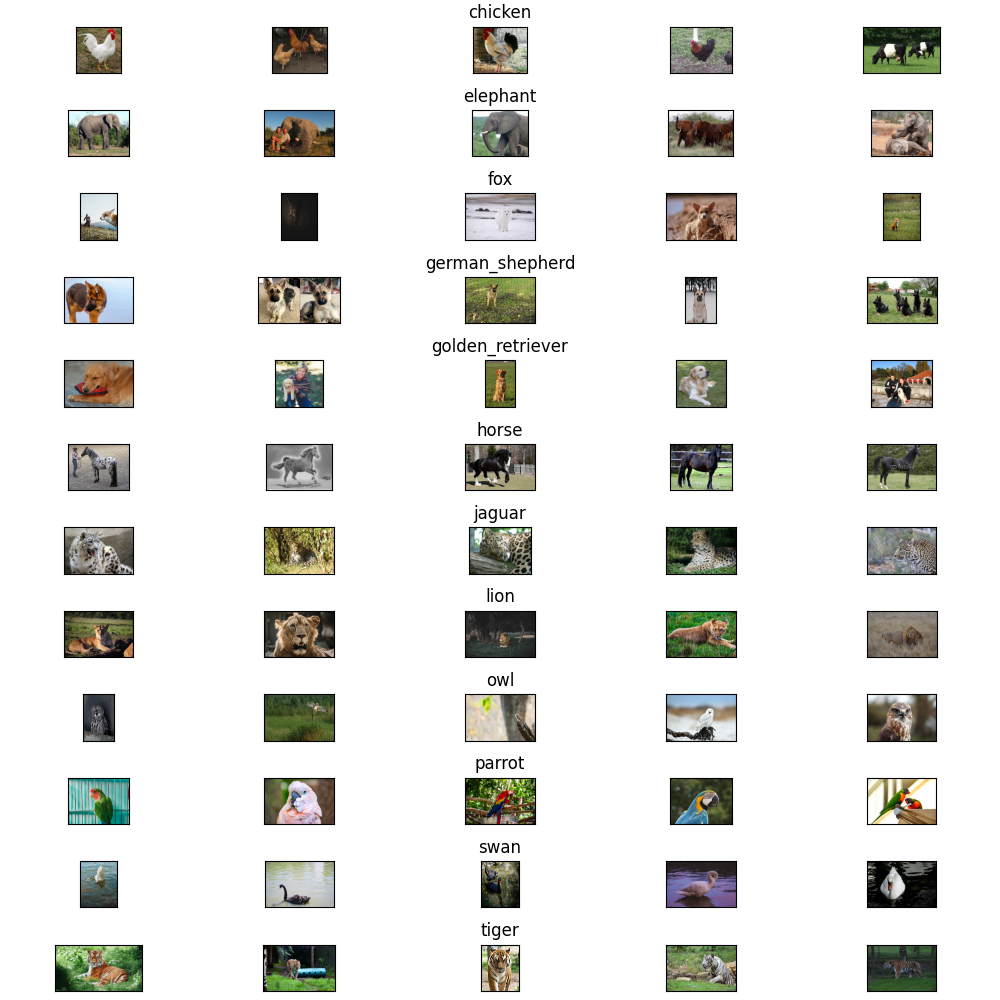

In [69]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=5, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(5):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 2: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    